# Import Libraries

In [96]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


# *Data Prep*

Training and Testing data is prepared from the solution file

In [97]:
data = scipy.io.loadmat('OriginalData/Burges_Pinns_train.mat')  	# Load data from file
x = data['x2']                                  # 256 points between -1 and 1 [256x1]
t = data['t2']                                   # 100 time points between 0 and 1 [100x1] 
nu =data['v2']
usol = data['usol_2']        # 1st dimension means space location, 2nd means time, 3rd means additional parameter                     

X, T, V = np.meshgrid(x,t, nu)  # if the sizes of x,t,nu are 50，100，5, then the size of X is 100*50*5   
Downloads/nif-main/nif-main/CITATION.cff

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [101]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None], V.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
usol_transposed = usol.transpose(1, 0, 2)
usol_reshaped = usol_transposed.reshape(101, 101, 5)
u_true = usol_reshaped.flatten('C')[:,None] 

print(X_u_test.shape,u_true.shape,lb,ub)
# 51005= 101* 101* 5

(51005, 3) (51005, 1) [0.    0.    0.014] [1.    1.    0.046]


# Training Data

In [102]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:,:].flatten()[:,None], T[0,:,:].flatten()[:,None], V[0,:,:].flatten()[:,None])) #L1
    leftedge_u = usol[:,0,:].flatten()[:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0,:].flatten()[:,None], T[:,0,:].flatten()[:,None], V[:,0,:].flatten()[:,None])) #L2
    bottomedge_u = usol[-1,:,:].flatten()[:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1,:].flatten()[:,None], T[:,-1,:].flatten()[:,None], V[:,-1,:].flatten()[:,None])) #L2
    topedge_u = usol[0,:,:].flatten()[:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(3,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# Physics Informed Neural Network

In [103]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        # u_b = torch.from_numpy(ub).float().to(device)
        # l_b = torch.from_numpy(lb).float().to(device)
                      
        # #preprocessing input 
        # x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
                        
        '''     
        Alternatively:
        
        a = self.activation(self.fc1(a))
        a = self.activation(self.fc2(a))
        a = self.activation(self.fc3(a))
        a = self.fc4(a)
        
        '''
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f):
        
        # nu = 0.01/np.pi
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
        nu    = x_to_train_f[:,[2]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]

        # print(u_t.shape,nu.shape,u_xx.shape)
        f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx 
        # f = u_t + (self.forward(g))*(u_x) -  torch.dot(nu.squeeze(), u_xx.squeeze())
        # print(torch.dot(nu.squeeze(), u_xx.squeeze()).shape)
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_u_train, u_train, X_f_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        
            print(loss,error_vec)

        return loss        
    
    'test neural network'
    def test(self):
                
        u_pred = self.forward(X_u_test_tensor)
        
        error_vec = torch.linalg.norm((u-u_pred),2)/torch.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = u_pred.cpu().detach().numpy()
        
        u_pred = np.reshape(u_pred,(101,101,5)) 
        u_pred = u_pred.transpose(1, 0, 2)      
        u_pred = u_pred.reshape(101,101,5)
                
        return error_vec, u_pred

# Main

In [104]:
'Generate Training data'
N_u = 100#*5 #Total number of data points for 'u'
N_f = 10_000#*5 #Total number of collocation points 
X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
u_train = torch.from_numpy(u_train_np_array).float().to(device)
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([3,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)
       
PINN.to(device)

'Neural Network Summary'
print(PINN)

params = list(PINN.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.1, 
                              max_iter = 20000, 
                              max_eval = None, 
                              tolerance_grad = 1e-05, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)


'Adam Optimizer'    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))


''' Solution Plot '''
# solutionplot(u_pred,X_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy())

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1-7): 7 x Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)
tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.5436, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3791, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0081, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3418, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0069, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2914, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.3004, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2920, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0054, device='cuda:0', grad_fn=<Add

' Solution Plot '

In [105]:
print(u_pred.shape,X_u_train.cpu().detach().numpy().shape,u_train.cpu().detach().numpy().shape)

(101, 101, 5) (100, 3) (100, 1)


# *Solution Plot*

In [106]:
def solutionplot(u_pred,X_u_train,u_train,zzz):
    # zzz=0
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred[:,:,zzz], interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)

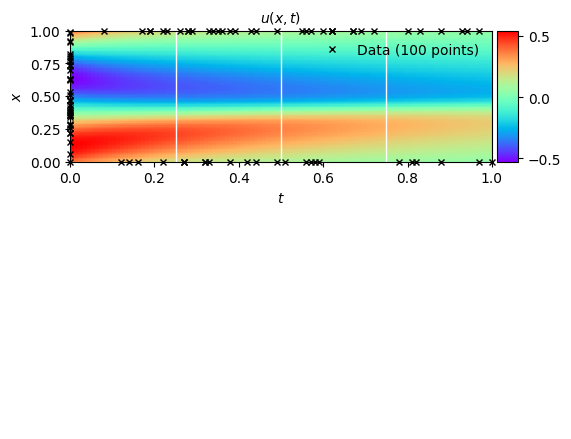

In [107]:
zzz=4  
solutionplot(u_pred,X_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy(),zzz)

# Testing results
## loading extrapolation testing data can get extrapolation predictions

In [116]:
data1 = scipy.io.loadmat('Burges_Pinns_test_interpolation.mat')  	# Load data from file
x1 = data1['x4']                                  
t1 = data1['t4']                                   
nu1 =data1['v4']
usol1 = data1['usol_4']                            

X1, T1, V1 = np.meshgrid(x1,t1, nu1)  

In [119]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test1 = np.hstack((X1.flatten()[:,None], T1.flatten()[:,None], V1.flatten()[:,None]))

# Domain bounds
# lb = X_u_test1[0]  # [-1. 0.]
# ub = X_u_test1[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
usol_transposed1 = usol1.transpose(1, 0, 2)
usol_reshaped1 = usol_transposed1.reshape(101, 101, 5)
u_true1 = usol_reshaped1.flatten('C')[:,None] 

print(X_u_test1.shape,u_true1.shape,lb,ub)
# 51005= 101* 101* 5

(51005, 3) (51005, 1) [0.    0.    0.014] [1.    1.    0.046]


In [120]:
X_u_test_tensor = torch.from_numpy(X_u_test1).float().to(device)

In [121]:
error_vec, u_pred1 = PINN.test()
print('Test Error: %.5f'  % (error_vec))

Test Error: 0.28560


In [122]:
def solutionplot1(u_pred1,X_u_train1,u_train1,zzz):
    # zzz=0
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred[:,:,zzz], interpolation='nearest', cmap='rainbow', 
                extent=[T1.min(), T1.max(), X1.min(), X1.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax) 

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)

C:\Users\DV Group\AppData\Local\Temp\ipykernel_75728\3181084626.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc = 'best')


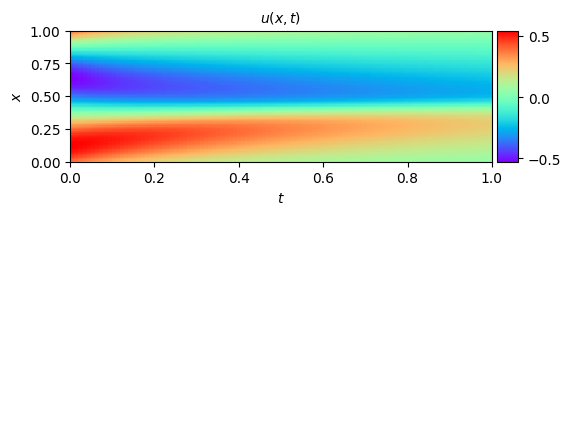

In [123]:
zzz=4   
solutionplot1(u_pred1,X_u_train.cpu().detach().numpy(),u_train.cpu().detach().numpy(),zzz)

# save testing predictions

In [124]:
from scipy.io import savemat
data = {
    "u_pred1": u_pred1,
    "u_true": usol1,
    "v_values": nu1,
    "x": x1,
    "t": t1,
}
# Save to a .mat file
savemat("interpolation_burger_pinns.mat",data)